In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [19]:
# Transformer encoder block
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim=128, num_heads=4, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn  = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.drop1 = nn.Dropout(dropout)

        self.norm2 = nn.LayerNorm(embed_dim)
        hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        attn_out, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + self.drop1(attn_out)      # residual 1
        x = x + self.mlp(self.norm2(x))   # residual 2
        return x


In [20]:
# building the ViT for CIFAR-10
class SmallViT(nn.Module):
    def __init__(self,
                 img_size=32,
                 patch_size=4,
                 in_chans=3,
                 num_classes=10,
                 embed_dim=128,
                 depth=4,
                 num_heads=4,
                 mlp_ratio=4.0,
                 dropout=0.1):
        super().__init__()

        assert img_size % patch_size == 0, "img_size must be divisible by patch_size"
        self.patch_size = patch_size

        num_patches = (img_size // patch_size) ** 2
        patch_dim = in_chans * patch_size * patch_size

        # Patch embedding
        self.patch_embed = nn.Linear(patch_dim, embed_dim)

        # CLS + positional embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop  = nn.Dropout(dropout)

        # Encoder blocks
        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        # x: (B, 3, 32, 32)
        B, C, H, W = x.shape
        p = self.patch_size

        # Split into patches: (B, C, H, W) -> (B, num_patches, patch_dim)
        x = x.unfold(2, p, p).unfold(3, p, p)          # (B, C, H/p, W/p, p, p)
        x = x.contiguous().view(B, C, -1, p, p)       # (B, C, num_patches, p, p)
        x = x.permute(0, 2, 1, 3, 4).contiguous()     # (B, num_patches, C, p, p)
        x = x.view(B, -1, C * p * p)                  # (B, num_patches, patch_dim)

        # Patch embeddings
        x = self.patch_embed(x)                        # (B, num_patches, embed_dim)

        # Add CLS token
        cls = self.cls_token.expand(B, -1, -1)         # (B, 1, embed_dim)
        x = torch.cat((cls, x), dim=1)                 # (B, num_patches+1, embed_dim)

        # Add position embeddings
        x = self.pos_drop(x + self.pos_embed)

        # Transformer encoder
        for blk in self.blocks:
            x = blk(x)

        # Classification using CLS token
        x = self.norm(x)
        logits = self.head(x[:, 0])                    # (B, num_classes)
        return logits

In [22]:
def train_small_vit(epochs=50, batch_size=128, lr=3e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_tfms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    test_tfms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_ds = datasets.CIFAR10("./data", train=True, download=True, transform=train_tfms)
    test_ds  = datasets.CIFAR10("./data", train=False, download=True, transform=test_tfms)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    model = SmallViT(embed_dim=128, depth=4, num_heads=4).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(1, epochs + 1):

        # Training the model
        model.train()
        correct, total, running_loss = 0, 0, 0.0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = logits.argmax(dim=1)
            total += y.size(0)
            correct += (preds == y).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation
        model.eval()
        correct, total, running_loss = 0, 0, 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = criterion(logits, y)

                running_loss += loss.item()
                preds = logits.argmax(dim=1)
                total += y.size(0)
                correct += (preds == y).sum().item()

        val_loss = running_loss / len(test_loader)
        val_acc = correct / total

        # Store metrics
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch:02d} | "
              f"Train Loss {train_loss:.4f} Acc {train_acc:.4f} | "
              f"Val Loss {val_loss:.4f} Acc {val_acc:.4f}")

    return model, history

In [23]:
model, history = train_small_vit()

Epoch 01 | Train Loss 1.8162 Acc 0.3215 | Val Loss 1.6697 Acc 0.3873
Epoch 02 | Train Loss 1.5471 Acc 0.4308 | Val Loss 1.4356 Acc 0.4818
Epoch 03 | Train Loss 1.4028 Acc 0.4923 | Val Loss 1.2996 Acc 0.5278
Epoch 04 | Train Loss 1.3237 Acc 0.5201 | Val Loss 1.2435 Acc 0.5483
Epoch 05 | Train Loss 1.2656 Acc 0.5420 | Val Loss 1.1713 Acc 0.5761
Epoch 06 | Train Loss 1.2186 Acc 0.5587 | Val Loss 1.1350 Acc 0.5838
Epoch 07 | Train Loss 1.1794 Acc 0.5739 | Val Loss 1.0902 Acc 0.6064
Epoch 08 | Train Loss 1.1470 Acc 0.5877 | Val Loss 1.0618 Acc 0.6156
Epoch 09 | Train Loss 1.1147 Acc 0.5990 | Val Loss 1.0260 Acc 0.6288
Epoch 10 | Train Loss 1.0897 Acc 0.6080 | Val Loss 1.0196 Acc 0.6294
Epoch 11 | Train Loss 1.0649 Acc 0.6143 | Val Loss 0.9972 Acc 0.6366
Epoch 12 | Train Loss 1.0388 Acc 0.6271 | Val Loss 0.9781 Acc 0.6462
Epoch 13 | Train Loss 1.0134 Acc 0.6359 | Val Loss 0.9435 Acc 0.6606
Epoch 14 | Train Loss 0.9943 Acc 0.6433 | Val Loss 0.9455 Acc 0.6581
Epoch 15 | Train Loss 0.9601 Acc 0

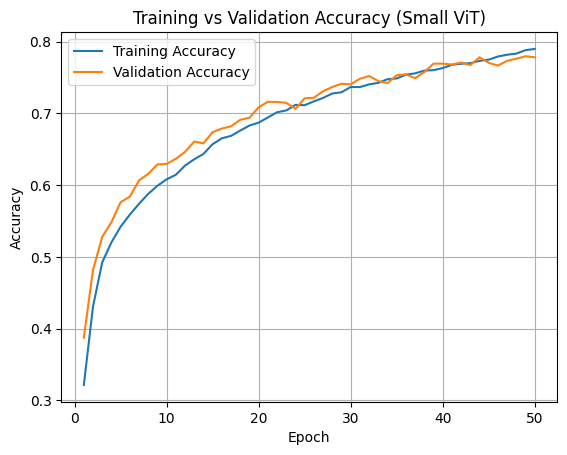

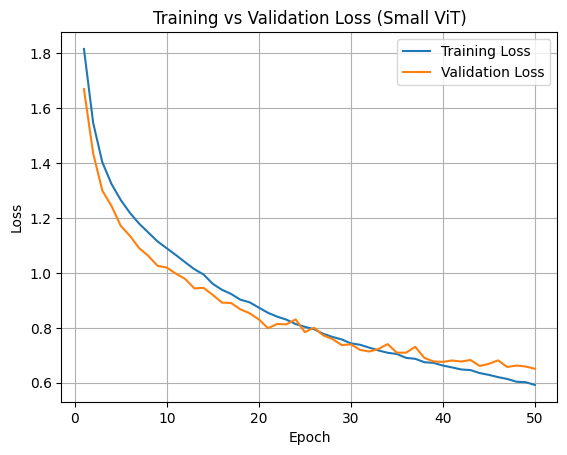

In [24]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    # Accuracy
    plt.figure()
    plt.plot(epochs, history["train_acc"], label="Training Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy (Small ViT)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure()
    plt.plot(epochs, history["train_loss"], label="Training Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss (Small ViT)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_curves(history)


In [27]:
@torch.no_grad()
def vit_confusion_matrix(model, test_loader, class_names, device):
    model.eval()

    y_true, y_pred = [], []

    for x, y in test_loader:
        x = x.to(device, non_blocking=True)

        logits = model(x)                  # (B, 10)
        preds = logits.argmax(dim=1).cpu() # predicted labels on CPU

        y_true.append(y)                   # true labels already on CPU
        y_pred.append(preds)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    # ----- Classification report -----
    print("Classification Report (ViT):")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # ----- Confusion matrix -----
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format="d", xticks_rotation=45)
    plt.title("Confusion Matrix (ViT)")
    plt.tight_layout()
    plt.show()


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Recreate the test_loader
test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_ds  = datasets.CIFAR10("./data", train=False, download=True, transform=test_tfms)
test_loader  = DataLoader(test_ds, batch_size=128, shuffle=False)

Classification Report (ViT):
              precision    recall  f1-score   support

    airplane     0.7939    0.7780    0.7859      1000
  automobile     0.8301    0.8940    0.8609      1000
        bird     0.6768    0.7560    0.7142      1000
         cat     0.6455    0.6010    0.6225      1000
        deer     0.8176    0.6860    0.7461      1000
         dog     0.6918    0.6980    0.6949      1000
        frog     0.8911    0.7940    0.8398      1000
       horse     0.7454    0.8580    0.7978      1000
        ship     0.8635    0.8670    0.8653      1000
       truck     0.8472    0.8480    0.8476      1000

    accuracy                         0.7780     10000
   macro avg     0.7803    0.7780    0.7775     10000
weighted avg     0.7803    0.7780    0.7775     10000



<Figure size 800x800 with 0 Axes>

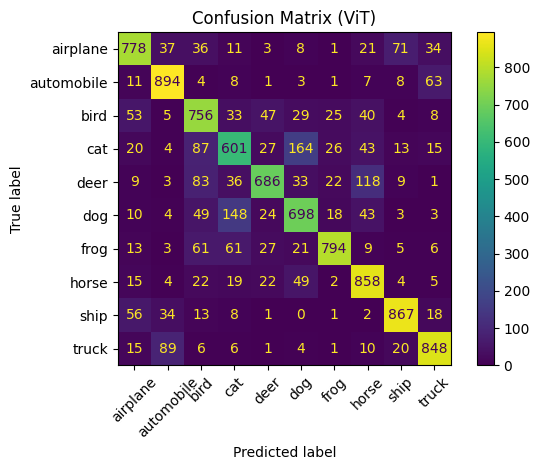

In [30]:
vit_confusion_matrix(model, test_loader, class_names, device)